# CSE473s Project

## Part 1 (XOR)
Implement our custom library, test it with [XOR] problem, validate it, and also implement the same exact problem using [TesnorFlow] or [Keras] then compare the results.

### Data initialization

In [24]:
import numpy as np

X = np.array([[-1, -1],[-1, 1],[1, -1],[1, 1]], dtype=np.float32)
y_true = np.array([[-1],[1],[1],[-1]], dtype=np.float32)

### Build netwrok with our custom library

In [25]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from lib import Sequential, Dense, Tanh, Sigmoid, ReLU, Softmax, MSELoss, SGDOptimizer as SGD

model = Sequential([
    Dense(2, 4, 0.1), Tanh(), Dense(4, 1, 0.1), Tanh()
])

opt = SGD(learning_rate=1.0)
loss_fn = MSELoss()

### Training loop

In [26]:
n_epochs = 10000

model.fit(X, y_true, loss_fn, opt, epochs=n_epochs)

Epoch 0, Loss: 0.5028910868776307
Epoch 100, Loss: 0.006397100531119953
Epoch 200, Loss: 0.0015097944294836217
Epoch 300, Loss: 0.0008301764062421813
Epoch 400, Loss: 0.0005673961760437525
Epoch 500, Loss: 0.0004291605515463737
Epoch 600, Loss: 0.0003442423381416053
Epoch 700, Loss: 0.00028692025087680476
Epoch 800, Loss: 0.0002456873655929047
Epoch 900, Loss: 0.00021463762239998203
Epoch 1000, Loss: 0.00019043294799102204
Epoch 1100, Loss: 0.00017104659478312287
Epoch 1200, Loss: 0.00015517785951379195
Epoch 1300, Loss: 0.00014195424047097166
Epoch 1400, Loss: 0.0001307689309676025
Epoch 1500, Loss: 0.00012118701348852482
Epoch 1600, Loss: 0.0001128887286291974
Epoch 1700, Loss: 0.0001056337945304998
Epoch 1800, Loss: 9.923820256773535e-05
Epoch 1900, Loss: 9.355868437182489e-05
Epoch 2000, Loss: 8.848204845278993e-05
Epoch 2100, Loss: 8.391769536745683e-05
Epoch 2200, Loss: 7.97922593510979e-05
Epoch 2300, Loss: 7.60457040788954e-05
Epoch 2400, Loss: 7.262843250429525e-05
Epoch 2500,

### Assert correctness

In [27]:
y_pred = model.forward(X)

print("Raw preds:\n", y_pred)
print("Rounded:\n", np.int8(np.round(y_pred)))

y_test = model.forward([-2.0, 3.0])
print("\nTest with random input (e.g.; [-2.0, 3.0]):", np.int8(np.round(y_test)))

Raw preds:
 [[-0.99560008]
 [ 0.99378287]
 [ 0.99393575]
 [-0.99432464]]
Rounded:
 [[-1]
 [ 1]
 [ 1]
 [-1]]

Test with random input (e.g.; [-2.0, 3.0]): [[1]]


### Plotting
Plotting the classifier boundary layers

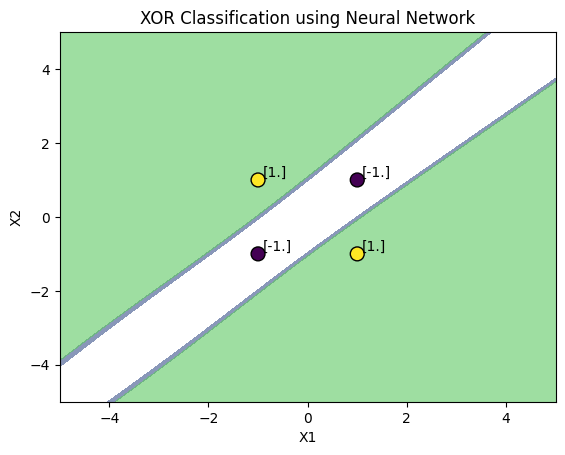

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of points for visualization
xx, yy = np.meshgrid(
    np.linspace(-5.0, 5.0, 200),
    np.linspace(-5.0, 5.0, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]  # shape (40000, 2)

# Predict on the grid
Z = model.forward(grid_points)  # shape (40000, 1)
Z = Z.reshape(xx.shape)         # reshape to (200, 200)

# Plot classification regions
plt.contourf(xx, yy, Z, levels=[0,0.5,1], alpha=0.6)

# Plot XOR data points
plt.scatter(X[:, 0], X[:, 1], s=100, c=y_true, edgecolors='k')
for i, txt in enumerate(y_true):
    plt.text(X[i, 0] + 0.1, X[i, 1] + 0.1, str(txt))

plt.title("XOR Classification using Neural Network")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### Section (1) [Gradient-Checking]
Proving that our backpropagation is correct, by comparing its gradients with the gradients of numerical gradient descent.

#### Numerical gradient descent function

In [29]:
import numpy as np

def numerical_gradient(model, X, y_true, loss_fn, epsilon=1e-5):
    numerical_grads = []

    for layer in model.layers:
        layer_grads = []

        if layer.trainable:
            for param in layer.params:
                grad = np.zeros_like(param)

                it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
                while not it.finished:
                    idx = it.multi_index
                    original_value = param[idx]

                    param[idx] = original_value + epsilon
                    loss_plus = loss_fn(y_true, model.forward(X))

                    param[idx] = original_value - epsilon
                    loss_minus = loss_fn(y_true, model.forward(X))

                    grad[idx] = (loss_plus - loss_minus) / (2 * epsilon)

                    param[idx] = original_value
                    it.iternext()
                
                layer_grads.append(grad)
        
        numerical_grads.append(layer_grads)

    return numerical_grads

#### Testing & comparing between our backprop and numerical gradient

In [30]:

# Compute numerical gradients
numerical_grads = numerical_gradient(model, X, y_true, loss_fn)
print("\nNumerical Gradients:")
for layer_idx, layer in enumerate(model.layers):
    if layer.trainable:
        print(f"Layer {layer_idx} ({type(layer).__name__}):")
        for param_idx, param in enumerate(layer.params):
            print(f" Param {param_idx} gradient:\n{numerical_grads[layer_idx][param_idx]}")

# Compare with backprop gradients
model.forward(X)
model.backward(loss_fn.backward())
print("\nBackprop Gradients:")
for layer_idx, layer in enumerate(model.layers):
    if layer.trainable:
        print(f"Layer {layer_idx} ({type(layer).__name__}):")
        for param_idx, grad in enumerate(layer.grads):
            print(f" Param {param_idx} gradient:\n{grad}")

# Check if numerical and backprop gradients are close
tolerance = 1e-4
for layer_idx, layer in enumerate(model.layers):
    if layer.trainable:
        for param_idx in range(len(layer.params)):
            num_grad = numerical_grads[layer_idx][param_idx]
            backprop_grad = layer.grads[param_idx]
            print(f"\nDifference for Layer {layer_idx} Param {param_idx}:\n", num_grad - backprop_grad)
            if not np.allclose(num_grad, backprop_grad, atol=tolerance):
                print(f"Gradient check failed for Layer {layer_idx} Param {param_idx}")
            else:
                print(f"Gradient check passed for Layer {layer_idx} Param {param_idx}")


Numerical Gradients:
Layer 0 (Dense):
 Param 0 gradient:
[[-4.49638688e-06 -7.17668702e-06  5.82676416e-06 -3.12770968e-06]
 [ 5.72969347e-06  5.98110956e-06  4.41395825e-06 -5.28071467e-06]]
 Param 1 gradient:
[[ 5.02779893e-06 -6.98981984e-06  7.16773353e-06  4.52576684e-06]]
Layer 2 (Dense):
 Param 0 gradient:
[[-2.23732204e-05]
 [ 2.33627263e-05]
 [ 8.95713382e-06]
 [ 6.05327838e-06]]
 Param 1 gradient:
[[-1.18805682e-05]]

Backprop Gradients:
Layer 0 (Dense):
 Param 0 gradient:
[[-4.49650106e-06 -7.17680635e-06  5.82667602e-06 -3.12760442e-06]
 [ 5.72978319e-06  5.98125257e-06  4.41384193e-06 -5.28065234e-06]]
 Param 1 gradient:
[[ 5.02749418e-06 -6.98941681e-06  7.16838002e-06  4.52626508e-06]]
Layer 2 (Dense):
 Param 0 gradient:
[[-2.23727049e-05]
 [ 2.33622552e-05]
 [ 8.95801827e-06]
 [ 6.05367640e-06]]
 Param 1 gradient:
[[-1.18818308e-05]]

Difference for Layer 0 Param 0:
 [[ 1.14177271e-10  1.19334190e-10  8.81344128e-11 -1.05262272e-10]
 [-8.97196745e-11 -1.43009375e-10  1

### Section (3) [Autoencoder]

In [31]:
import numpy as np
import sys, os
sys.path.insert(0, os.path.abspath('..')) 

from lib import Sequential, Dense, ReLU, Sigmoid, MSELoss, SGDOptimizer as SGD
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1, as_frame=False) 
X_mnist = mnist.data.astype(np.float32) / 255.0
y_mnist = mnist.target.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, test_size=0.2, random_state=42)

In [32]:
# 3. Define Autoencoder
autoencoder = Sequential([
    Dense(784, 128, 0.1), ReLU(),
    Dense(128, 64, 0.1), ReLU(),
    Dense(64, 32, 0.1), ReLU(),
    Dense(32, 64, 0.1), ReLU(),
    Dense(64, 128, 0.1), ReLU(),
    Dense(128, 784, 0.1), Sigmoid()
])

In [33]:
from tqdm import tqdm

optimizer = SGD(learning_rate=0.005)
loss_fn = MSELoss()

epochs = 10
batch_size = 64

print("Starting training...")

for epoch in range(epochs):
    
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train_shuffled = X_train[indices]
    
    epoch_loss = 0
    num_batches = 0

    for i in tqdm(range(0, X_train.shape[0], batch_size), 
                  desc=f"Epoch {epoch+1}/{epochs}", 
                  unit="batch"):
        
        X_batch = X_train_shuffled[i:i + batch_size]
        
        batch_loss = autoencoder.train_step(X_batch, X_batch, loss_fn, optimizer)
        
        epoch_loss += batch_loss
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    print(f"Loss: {avg_loss:.4f}")

Starting training...


Epoch 1/10: 100%|██████████| 875/875 [00:02<00:00, 304.37batch/s]


Loss: 0.0367


Epoch 2/10: 100%|██████████| 875/875 [00:02<00:00, 334.52batch/s]


Loss: 0.0256


Epoch 3/10: 100%|██████████| 875/875 [00:04<00:00, 201.23batch/s]


Loss: 0.0206


Epoch 4/10: 100%|██████████| 875/875 [00:03<00:00, 277.43batch/s]


Loss: 0.0178


Epoch 5/10: 100%|██████████| 875/875 [00:03<00:00, 271.16batch/s]


Loss: 0.0163


Epoch 6/10: 100%|██████████| 875/875 [00:02<00:00, 384.22batch/s]


Loss: 0.0152


Epoch 7/10: 100%|██████████| 875/875 [00:02<00:00, 371.09batch/s]


Loss: 0.0143


Epoch 8/10: 100%|██████████| 875/875 [00:02<00:00, 347.95batch/s]


Loss: 0.0136


Epoch 9/10: 100%|██████████| 875/875 [00:03<00:00, 255.05batch/s]


Loss: 0.0130


Epoch 10/10: 100%|██████████| 875/875 [00:03<00:00, 268.63batch/s]

Loss: 0.0125


reconstructing...


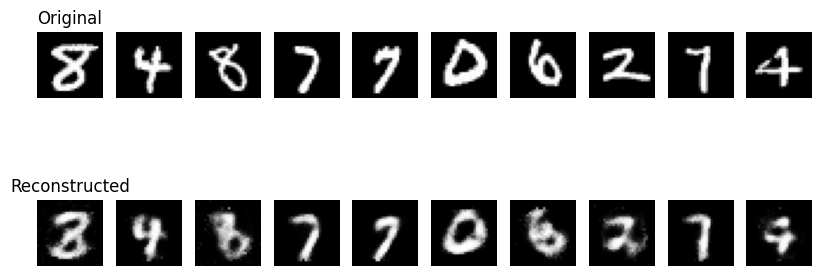

In [34]:
# 5. Evaluate
print("reconstructing...")
X_test_reconstructed = autoencoder.forward(X_test[:1000]) # Predict on a subset to save memory if needed

# 6. Visualize
n_samples = 10
plt.figure(figsize=(10, 4))
for i in range(n_samples):
    # Original
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')

    # Reconstructed
    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(X_test_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')
plt.show()

In [36]:
from lib import Sequential, Dense, ReLU, Sigmoid, MSELoss, SGDOptimizer as SGD  # [file:2]
encoder = Sequential(autoencoder.layers[:6])

def extract_features(model, X, bs=512):
    out = []
    for i in range(0, X.shape[0], bs):
        out.append(model.forward(X[i:i+bs]))
    return np.vstack(out)

Z_train = extract_features(encoder, X_train)
Z_test  = extract_features(encoder, X_test)



Accuracy: 0.8654285714285714
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1343
           1       0.94      0.97      0.96      1600
           2       0.85      0.85      0.85      1380
           3       0.82      0.84      0.83      1433
           4       0.82      0.86      0.84      1295
           5       0.78      0.71      0.74      1273
           6       0.92      0.92      0.92      1396
           7       0.90      0.91      0.90      1503
           8       0.82      0.81      0.81      1357
           9       0.85      0.81      0.83      1420

    accuracy                           0.87     14000
   macro avg       0.86      0.86      0.86     14000
weighted avg       0.86      0.87      0.86     14000



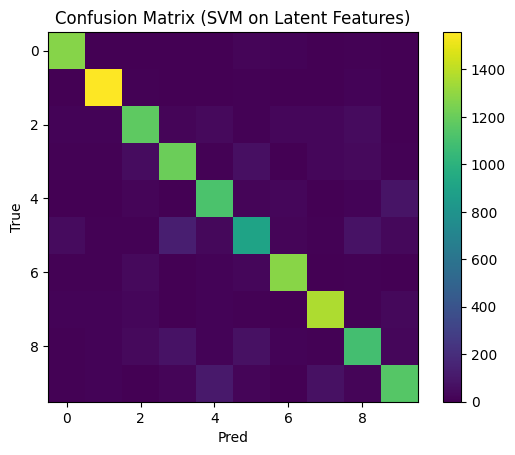

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

svm = make_pipeline(StandardScaler(), LinearSVC(C=1.0))
svm.fit(Z_train, y_train)

y_pred = svm.predict(Z_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (SVM on Latent Features)")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()
plt.show()


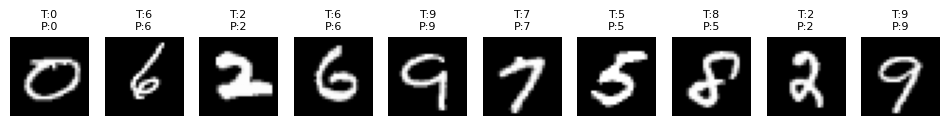

In [44]:
def show_random(n=12):
    idxs = np.random.choice(len(X_test), size=n, replace=False)
    plt.figure(figsize=(12,3))
    for j, idx in enumerate(idxs):
        x = X_test[idx]
        true = y_test[idx]
        pred = svm.predict(Z_test[idx:idx+1])[0]

        plt.subplot(1, n, j+1)
        plt.imshow((x.reshape(28,28)*255).astype(np.uint8), cmap="gray")
        plt.title(f"T:{true}\nP:{pred}", fontsize=8)
        plt.axis("off")
    plt.show()

show_random(10)
